In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandasql as ps
import pyspark
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('practice').getOrCreate()#создание сессии
flight_data = spark.read.csv("flights.csv", header=True, inferSchema=True)

In [3]:
#создаем представление таблицы полетов
flight_data.createOrReplaceTempView("flights")

# Анализ данных

In [4]:
#1
#Количество рейсов по месяцам

count_month = spark.sql('''SELECT MONTH,COUNT(MONTH) AS COUNT_IN_MONTH
FROM flights
GROUP BY MONTH''')

count_month.show()

+-----+--------------+
|MONTH|COUNT_IN_MONTH|
+-----+--------------+
|    1|        469968|
|    2|        429191|
|    3|        504312|
|    4|        485151|
|    5|        496993|
|    6|        503897|
|    7|        520718|
|    8|        510536|
|    9|        464946|
|   10|        486165|
|   11|        467972|
|   12|        479230|
+-----+--------------+



<BarContainer object of 12 artists>

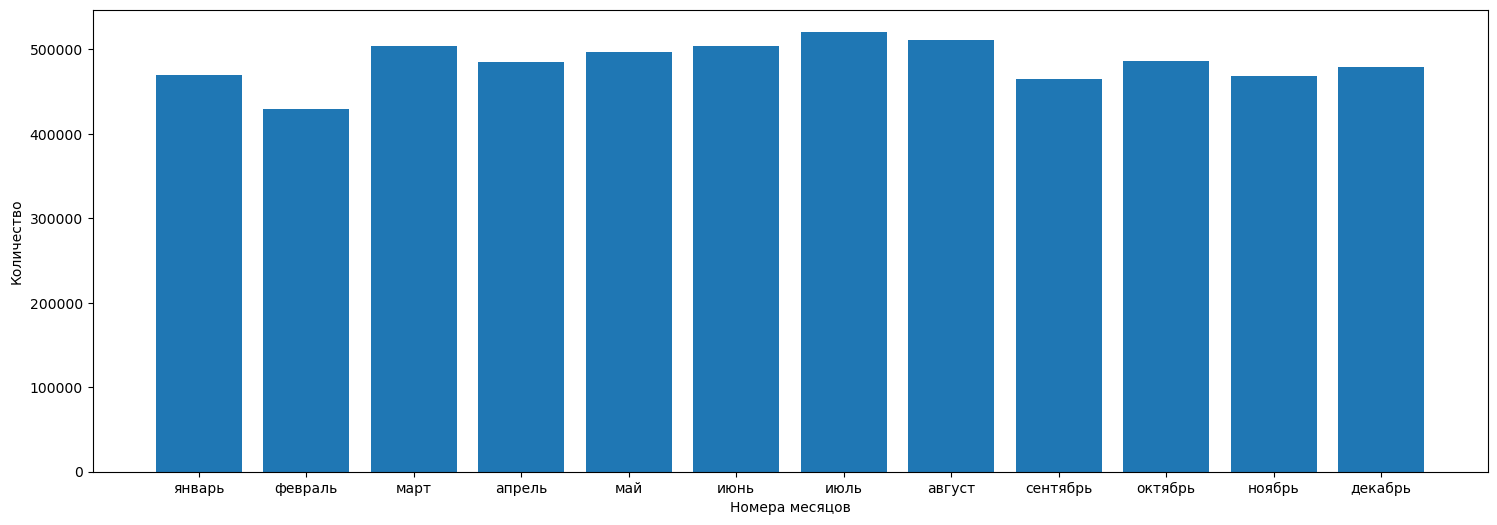

In [5]:
month_mas = [list(row) for row in count_month.collect()]
month_names = ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь']
plt.figure(figsize=(18,6))
plt.xlabel('Номера месяцов')
plt.ylabel('Количество')
plt.bar(month_names,[count[1] for count in month_mas])

In [6]:
print(f"Пик приходится на июль, спад приходится на февраль")

Пик приходится на июль, спад приходится на февраль


In [8]:
#2
#Количество рейсов в днях недели
count_days_week = spark.sql('''SELECT DAY_OF_WEEK,COUNT(DAY_OF_WEEK) COUNT_IN_DAY_OF_WEEK
FROM flights
GROUP BY DAY_OF_WEEK
ORDER BY DAY_OF_WEEK
''')

count_days_week.show()

+-----------+--------------------+
|DAY_OF_WEEK|COUNT_IN_DAY_OF_WEEK|
+-----------+--------------------+
|          1|              865543|
|          2|              844600|
|          3|              855897|
|          4|              872521|
|          5|              862209|
|          6|              700545|
|          7|              817764|
+-----------+--------------------+



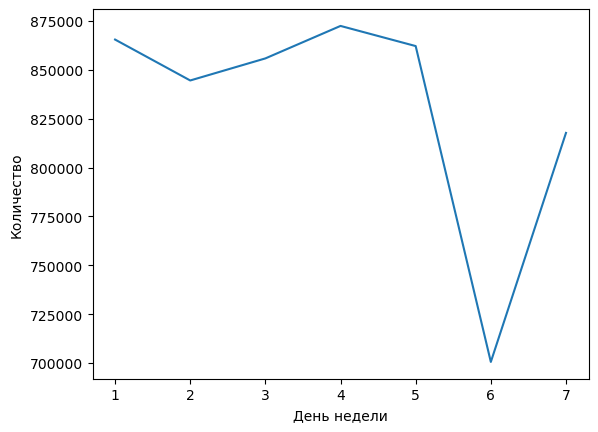

In [9]:
days_week_mas = [list(row) for row in count_days_week.collect()]
plt.xlabel("День недели")
plt.ylabel("Количество")
plt.plot([count[0] for count in days_week_mas],[count[1] for count in days_week_mas])

### Похоже на экспоненциальное распределение

In [13]:
#проверяем распределение количества рейсов по дням недели по критерию Колмогорова
loc,scale = ss.expon.fit([count[1] for count in days_week_mas])
ss.kstest([count[1] for count in days_week_mas], cdf=ss.expon(loc,scale).cdf)

KstestResult(statistic=0.44914718622300137, pvalue=0.08336344118875538)

In [4]:
#3
data_airports = spark.read.csv("airports.csv", header=True, inferSchema=True)
data_airports.createOrReplaceTempView("airports")
data_airports.show()

+---------+--------------------+-------------+-----+-------+--------+----------+
|IATA_CODE|             AIRPORT|         CITY|STATE|COUNTRY|LATITUDE| LONGITUDE|
+---------+--------------------+-------------+-----+-------+--------+----------+
|      ABE|Lehigh Valley Int...|    Allentown|   PA|    USA|40.65236|  -75.4404|
|      ABI|Abilene Regional ...|      Abilene|   TX|    USA|32.41132|  -99.6819|
|      ABQ|Albuquerque Inter...|  Albuquerque|   NM|    USA|35.04022|-106.60919|
|      ABR|Aberdeen Regional...|     Aberdeen|   SD|    USA|45.44906| -98.42183|
|      ABY|Southwest Georgia...|       Albany|   GA|    USA|31.53552| -84.19447|
|      ACK|Nantucket Memoria...|    Nantucket|   MA|    USA|41.25305| -70.06018|
|      ACT|Waco Regional Air...|         Waco|   TX|    USA|31.61129| -97.23052|
|      ACV|      Arcata Airport|Arcata/Eureka|   CA|    USA|40.97812|-124.10862|
|      ACY|Atlantic City Int...|Atlantic City|   NJ|    USA|39.45758| -74.57717|
|      ADK|        Adak Airp

In [12]:
#группировка по аэропорту вылета
from_city = spark.sql('''
SELECT CITY,COUNT(CITY)
FROM (flights
INNER JOIN airports
ON flights.ORIGIN_AIRPORT = airports.IATA_CODE)
GROUP BY CITY
ORDER BY CITY
''')

#группировка по аэропорту прилета
to_city = spark.sql('''
SELECT CITY,COUNT(CITY)
FROM (flights
INNER JOIN airports
ON flights.DESTINATION_AIRPORT = airports.IATA_CODE)
GROUP BY CITY
ORDER BY CITY
''')

#соединяем две таблицы по аэропорту сверху и считаем сумму количесв
all_cities = spark.sql('''
SELECT A1.CITY,(COUNT_CITY1+COUNT_CITY2) AS COUNT_ALL
FROM (SELECT CITY,COUNT(CITY) AS COUNT_CITY1
FROM (flights
INNER JOIN airports
ON flights.ORIGIN_AIRPORT = airports.IATA_CODE)
GROUP BY CITY
ORDER BY CITY) A1
FULL JOIN
(SELECT CITY,COUNT(CITY) AS COUNT_CITY2
FROM (flights
INNER JOIN airports
ON flights.DESTINATION_AIRPORT = airports.IATA_CODE)
GROUP BY CITY
ORDER BY CITY) A2
ON A1.CITY = A2.CITY
ORDER BY COUNT_ALL DESC
LIMIT 10

''')

all_cities.show()

+-----------------+---------+
|             CITY|COUNT_ALL|
+-----------------+---------+
|          Chicago|   733560|
|          Atlanta|   693740|
|Dallas-Fort Worth|   479133|
|          Houston|   397388|
|           Denver|   392065|
|      Los Angeles|   389369|
|         New York|   386806|
|    San Francisco|   295974|
|          Phoenix|   293627|
|        Las Vegas|   266379|
+-----------------+---------+



In [5]:
#4
airlines_data = spark.read.csv("airlines.csv", header=True, inferSchema=True)
airlines_data.createOrReplaceTempView("airlines")

In [13]:
top.show()

+--------------------+------+
|             AIRPORT|    CC|
+--------------------+------+
|Hartsfield-Jackso...|346836|
|Chicago O'Hare In...|285884|
|Dallas/Fort Worth...|239551|
|Denver Internatio...|196055|
|Los Angeles Inter...|194673|
|San Francisco Int...|148008|
|Phoenix Sky Harbo...|146815|
|George Bush Inter...|146622|
|McCarran Internat...|133181|
|Minneapolis-Saint...|112117|
+--------------------+------+



In [14]:
#соединяем flights и airlines, по коду и группируем по авиакомпании
top_airports= spark.sql('''
SELECT AIRLINE,COUNT(AIRLINE) AS COUNT_AIRLINE
FROM (SELECT airlines.AIRLINE
FROM flights
INNER JOIN airlines
ON flights.AIRLINE = airlines.IATA_CODE) 
GROUP BY AIRLINE
ORDER BY COUNT_AIRLINE DESC
LIMIT 10
''')

top_airports.show()

+--------------------+-------------+
|             AIRLINE|COUNT_AIRLINE|
+--------------------+-------------+
|Southwest Airline...|      1261855|
|Delta Air Lines Inc.|       875881|
|American Airlines...|       725984|
|Skywest Airlines ...|       588353|
|Atlantic Southeas...|       571977|
|United Air Lines ...|       515723|
|American Eagle Ai...|       294632|
|     JetBlue Airways|       267048|
|     US Airways Inc.|       198715|
|Alaska Airlines Inc.|       172521|
+--------------------+-------------+



In [16]:
#компания с самым большим количеством рейсов 
[list(row)[0] for row in top_airports.collect()][0]

'Southwest Airlines Co.'

# Исследование данных

#### Группируем среднее задержок по аэропортам

In [19]:
#1
#1.сначала соединяем airports и flights по аэропорту вылета, выводим аэропорт и задержку вылета
#2.далее группируем по аэропорту среднее задержок и находим самую минимальную задержку
delay_airport = spark.sql('''
SELECT AIRPORT,AVG(DEPARTURE_DELAY) AS MINIMUM
FROM (SELECT AIRPORT,DEPARTURE_DELAY
FROM airports
INNER JOIN flights
ON flights.ORIGIN_AIRPORT = airports.IATA_CODE)
GROUP BY AIRPORT
ORDER BY MINIMUM
LIMIT 1
''')

### Аэропорт с минимальной задержкой 

In [20]:
delay_airport.show()

+---------------+------------------+
|        AIRPORT|           MINIMUM|
+---------------+------------------+
|Yakutat Airport|-6.292237442922374|
+---------------+------------------+



In [21]:
#берем код выше и вычисляем среднее
delay_airports_top = spark.sql('''
SELECT AVG(MINIMUM) AS MEAN_DELAY
FROM (SELECT AIRPORT,AVG(DEPARTURE_DELAY) AS MINIMUM
FROM (SELECT AIRPORT,DEPARTURE_DELAY
FROM airports
INNER JOIN flights
ON flights.ORIGIN_AIRPORT = airports.IATA_CODE)
GROUP BY AIRPORT
ORDER BY MINIMUM
LIMIT 10)
''')

### Средняя задержка вылета для аэропортов из топ-10 по количеству рейсов

In [8]:
avg_aeroport = spark.sql('''
SELECT AIRPORT,AVG(DEPARTURE_DELAY) AS MAXIMUM
FROM (SELECT AIRPORT,DEPARTURE_DELAY
FROM airports
INNER JOIN flights
ON flights.ORIGIN_AIRPORT = airports.IATA_CODE)
GROUP BY AIRPORT
ORDER BY MAXIMUM DESC
LIMIT 10
''')

top = spark.sql('''
SELECT AIRPORT,COUNT(AIRPORT) AS CC
FROM (SELECT AIRPORT
FROM airports 
INNER JOIN flights
ON flights.ORIGIN_AIRPORT = airports.IATA_CODE)
GROUP BY AIRPORT
ORDER BY CC DESC
LIMIT 10
''')

full = spark.sql('''
SELECT AVG(MAXIMUM) AS MEAN_AIRPORTS
FROM (SELECT A1.AIRPORT,CC,MAXIMUM
FROM (SELECT AIRPORT,AVG(DEPARTURE_DELAY) AS MAXIMUM
FROM (SELECT AIRPORT,DEPARTURE_DELAY
FROM airports
INNER JOIN flights
ON flights.ORIGIN_AIRPORT = airports.IATA_CODE)
GROUP BY AIRPORT
ORDER BY MAXIMUM DESC) A1
INNER JOIN (SELECT AIRPORT,COUNT(AIRPORT) AS CC
FROM (SELECT AIRPORT
FROM airports 
INNER JOIN flights
ON flights.ORIGIN_AIRPORT = airports.IATA_CODE)
GROUP BY AIRPORT
ORDER BY CC DESC
LIMIT 10) A2
ON A1.AIRPORT = A2.AIRPORT) B
''')

full.show()

+------------------+
|     MEAN_AIRPORTS|
+------------------+
|10.717525314776925|
+------------------+



### Среднее из топ 10 минимальных задержек 

In [22]:
delay_airports_top.show()

+-------------------+
|         MEAN_DELAY|
+-------------------+
|-2.9253963464547903|
+-------------------+



In [23]:
#2
punct_company = spark.sql('''
SELECT IATA_CODE
FROM (SELECT IATA_CODE,RANK() OVER(ORDER BY IATA_CODE DESC) AS rank
FROM airports)
WHERE rank = 232
''')

### Мой аэропорт

In [24]:
punct_company.show()

+---------+
|IATA_CODE|
+---------+
|      DLH|
+---------+



### Соединяем airlines и flights по airline, группируем по авиакомпании (берем среднее), и выводим компанию и минимальную задержку прилета

In [115]:
#1.соединяем airlines и flights по коду,в условии где аэропорт прилета равен моему аэропорту
#2.группируем средние по авиакомпаниям и выводим все с самой минимальной задержкой прилета
company_all = spark.sql('''
SELECT  AIRLINE,AVG(ARRIVAL_DELAY) AS MEAN_DELAY
FROM (SELECT airlines.AIRLINE,DESTINATION_AIRPORT,ARRIVAL_DELAY
FROM airlines
INNER JOIN flights
ON airlines.IATA_CODE = flights.AIRLINE
WHERE DESTINATION_AIRPORT = "DLH")
GROUP BY AIRLINE
ORDER BY MEAN_DELAY
LIMIT 1
''')

company_all.show()

+--------------------+------------------+
|             AIRLINE|        MEAN_DELAY|
+--------------------+------------------+
|Delta Air Lines Inc.|-6.150753768844221|
+--------------------+------------------+



### Аэропорт с самым большим временем на взлетной и посадочной полосе 

In [50]:
#3
#TAXI_OUT - руление самолета когда он взлетает, TAXI_IN - руление самолета когда его сажают

#Под рулением понимается движение самолета по взлетно-посадочной полосе
#группирование среднего времен взлета по аэропорту 
air_airplane_out = spark.sql('''
SELECT AIRPORT,AVG(TAXI_OUT) AS MEAN_TAXI_OUT
FROM (SELECT TAXI_OUT,ORIGIN_AIRPORT,AIRPORT
FROM flights
INNER JOIN airports
ON flights.ORIGIN_AIRPORT = airports.IATA_CODE)
GROUP BY AIRPORT
''')

#группирование среднего времен прилета по аэропорту 
air_airplane_in = spark.sql('''
SELECT AIRPORT,AVG(TAXI_IN) AS MEAN_TAXI_IN
FROM (SELECT TAXI_IN,DESTINATION_AIRPORT,AIRPORT
FROM flights
INNER JOIN airports
ON flights.DESTINATION_AIRPORT = airports.IATA_CODE)
GROUP BY AIRPORT
''')


#соединение верхних таблиц по аэроопорту и нахождение суммы taxi
air_airplane = spark.sql('''
SELECT A1.AIRPORT,(MEAN_TAXI_IN+MEAN_TAXI_OUT) AS TAXI
FROM (SELECT AIRPORT,AVG(TAXI_OUT) AS MEAN_TAXI_OUT
FROM (SELECT TAXI_OUT,ORIGIN_AIRPORT,AIRPORT
FROM flights
INNER JOIN airports
ON flights.ORIGIN_AIRPORT = airports.IATA_CODE)
GROUP BY AIRPORT) A1
INNER JOIN (SELECT AIRPORT,AVG(TAXI_IN) AS MEAN_TAXI_IN
FROM (SELECT TAXI_IN,DESTINATION_AIRPORT,AIRPORT
FROM flights
INNER JOIN airports
ON flights.DESTINATION_AIRPORT = airports.IATA_CODE)
GROUP BY AIRPORT) A2
ON A1.AIRPORT = A2.AIRPORT
ORDER BY TAXI DESC
LIMIT 1
''')

air_airplane.show()

+--------------------+------------------+
|             AIRPORT|              TAXI|
+--------------------+------------------+
|John F. Kennedy I...|35.752036330710624|
+--------------------+------------------+



In [51]:
[list(row)[0] for row in air_airplane.collect()][0]

'John F. Kennedy International Airport\xa0(New York International Airport)'